In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import cirq
from qpe import generate_qpe_circuit
from cirq import ZPowGate
from cirq import depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp
import numpy as np
from tqdm import tqdm

phase = 5/16
U = ZPowGate(exponent=phase*2)
circuit, t, control, target = generate_qpe_circuit(U, 1, t=4)
# circuit, t, control, target = generate_qpe_circuit(U, 1, eps=0.3)
print(f't = {t}')
# print(dir(circuit))
print(f'depth = {len(circuit)}')

# Measure and print the results
circuit_with_measurement = circuit.copy()
circuit_with_measurement.append(cirq.measure(*control, key='result'))

s=cirq.Simulator()
print('Sampling the circuit:')
samples=s.run(circuit_with_measurement, repetitions=1000)
# Print a histogram of results
counts = samples.histogram(key='result')
print(counts)
most_freq_bitstring = sorted(counts, key=lambda k: counts[k], reverse=True)[0]
print(f'𝜙 = {most_freq_bitstring/2**t}')
exact = int(most_freq_bitstring)

t = 4
depth = 17
Sampling the circuit:
Counter({5: 1000})
𝜙 = 0.3125


In [3]:
from typing import Tuple
from mitiq import Executor, Observable, PauliString, MeasurementResult
from mitiq.interface import mitiq_cirq
from mitiq.zne import execute_with_zne
from cirq import X, I

paulis = []
paulis.append(PauliString("I", coeff=0.5*(2**t-1)))
for p in range(t):    
    paulis.append(PauliString("Z", coeff=0.5*-2**(t-1-p), support=(p,)))
obs = Observable(*paulis)
print(obs)

def simulate(circuit: cirq.Circuit) -> np.ndarray:
    return mitiq_cirq.compute_density_matrix(circuit, noise_level=(0.0,))

def execute_noisy(circuit: cirq.Circuit) -> MeasurementResult:
    return mitiq_cirq.sample_bitstrings(circuit, noise_level=(0.01,))

executor = Executor(mitiq_cirq.compute_density_matrix)
value = obs.expectation(circuit, execute=simulate).real
print(value)

value = obs.expectation(circuit, execute=execute_noisy).real
print(value)

zne_value = execute_with_zne(circuit, execute_noisy, obs).real
zne_value = max(min(zne_value, 2**t - 1), -2**t - 1)
print(zne_value)

(7.5+0j)*I + (-4+0j)*Z(0) + (-2+0j)*Z(1) + -Z(2) + (-0.5+0j)*Z(3)
4.9999987871790434
5.1116943359375
4.8464355468749964


In [10]:
from mitiq.zne import RichardsonFactory

num_to_average = 25
shots = 1024
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.02, 0.04, 0.06, 0.08, 0.1]
scale_factors = [1.0, 3.0, 5.0, 7.0]
results = {}

for nm in noise_models:
    exp_vals = []
    all_exp_values = {}
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
        factory = RichardsonFactory(scale_factors=scale_factors)
        exp_val = execute_with_zne(circuit, execute_with_noise, obs, factory=factory, num_to_average=num_to_average).real
        all_exp_vals = factory.get_expectation_values()
        all_exp_values[noise_level] = np.real(all_exp_vals)
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals, all_exp_values

100%|██████████| 5/5 [15:50<00:00, 190.04s/it]


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

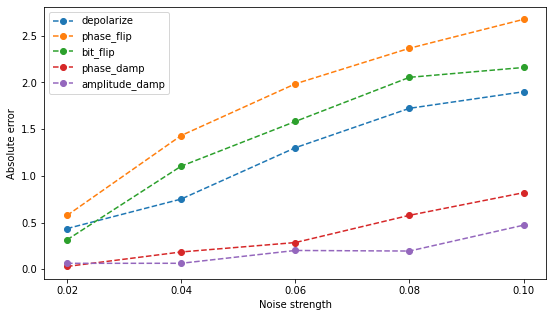

In [14]:
plt.figure(figsize=(9, 5))
for nm, (exp_vals, _) in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

plt.xlabel("Noise strength")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
plt.savefig('images/zne_noise_models.png', dpi=300, facecolor='white')
plt.show();

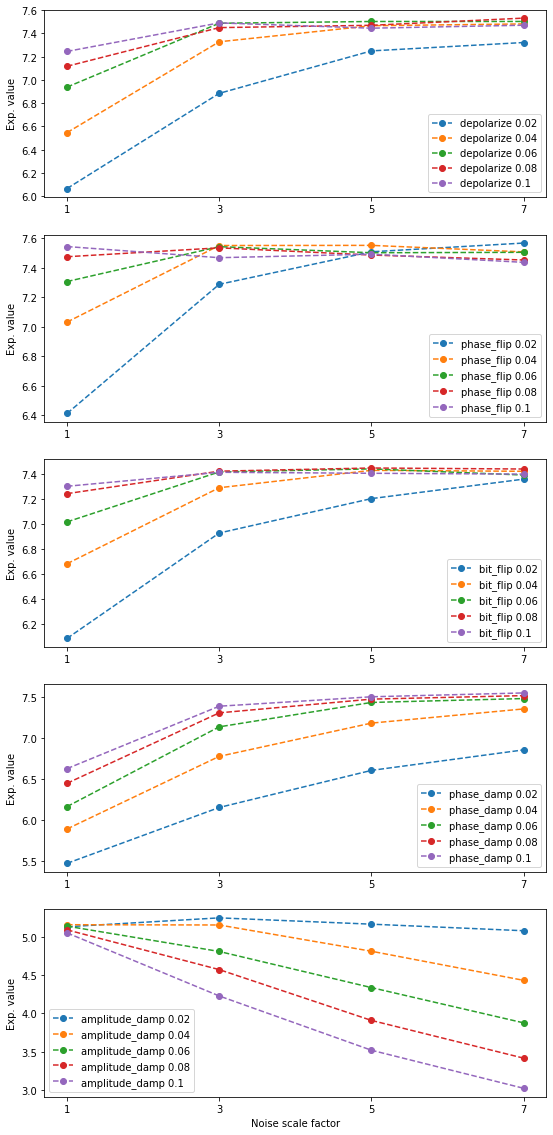

In [31]:
fig, ax = plt.subplots(len(noise_levels), 1, figsize=(9, 20))
for i, item in enumerate(results.items()):
    nm, (exp_vals, all_exp_values) = item
    for nl, all_exp_vals in all_exp_values.items():
        ax[i].plot(scale_factors, all_exp_vals, "--o", label=f"{nm} {nl}")
        ax[i].set_ylabel("Exp. value")
        ax[i].set_xticks(scale_factors)
        ax[i].legend()

ax[-1].set_xlabel("Noise scale factor")
        
plt.savefig('images/zne_noise_scaling.png', dpi=300, facecolor='white')
plt.show();

In [ ]:
# NOTE: CDR just doesn't seem to scale well beyond depths of 40 or more than 1 qubit, so in retrospect it isn't really a good match
# for our QPE circuit (i.e. - I would have cut it from the original paper)
from mitiq.pec.pec import execute_with_pec
from mitiq.pec.representations import represent_operations_in_circuit_with_local_depolarizing_noise, _represent_operation_with_amplitude_damping_noise

shots = 1024
noise_models = [depolarize, amplitude_damp] # phase_flip, bit_flip, phase_damp not supported for PEC
noise_levels = [0.02] #, 0.04, 0.06, 0.08, 0.1]
results = {}
print(len(circuit))
for nm in noise_models:
    exp_vals = []
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
        if nm == depolarize:        
            representations = represent_operations_in_circuit_with_local_depolarizing_noise(circuit, noise_level=noise_level)
        elif nm == amplitude_damp:
            representations = _represent_operation_with_amplitude_damping_noise(circuit, noise_level=noise_level)
        
#         for r in representations:
#             print(r.ideal)
        
        exp_value = execute_with_pec(
            circuit=circuit,
            executor=execute_with_noise,
            observable=obs,
            representations=representations,
            precision=1.0,
#             precision=(0.2 * (i+1)),
#             full_output=True
#     )   
#             num_samples = num_samples,
        )
        exp_vals.append(exp_value)
    
    results[nm.__name__] = exp_vals

In [12]:
from mitiq import cdr

num_to_average = 25
num_train = 30
shots = 1024
noise_models = [depolarize, phase_flip, bit_flip, phase_damp, amplitude_damp]
noise_levels = [0.02, 0.04, 0.06, 0.08, 0.1]

results = {}

for nm in noise_models:
    exp_vals = []
    all_exp_values = {}
    for noise_level in tqdm(noise_levels):
        execute_with_noise = partial(mitiq_cirq.sample_bitstrings, noise_model=nm, noise_level=(noise_level,), shots=shots)
        cirq.ConvertToCzAndSingleGates().optimize_circuit(circuit)
        exp_val = cdr.execute_with_cdr(circuit,execute_with_noise,observable=obs,simulator=simulate,num_to_average=num_to_average,num_training_circuits=num_train,).real
        exp_vals.append(exp_val)
    
    results[nm.__name__] = exp_vals

  0%|          | 0/5 [00:00<?, ?it/s]/home/amir/miniconda3/envs/mitiq/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
100%|██████████| 5/5 [04:15<00:00, 51.17s/it]


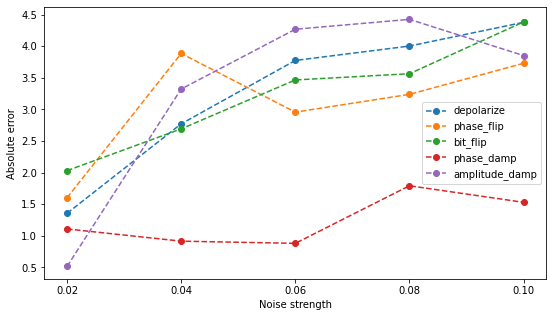

In [15]:
plt.figure(figsize=(9, 5))
for nm, exp_vals in results.items():
    plt.plot(noise_levels, np.abs(np.array(exp_vals) - exact), "--o", label=nm)

plt.xlabel("Noise strength")
plt.ylabel("Absolute error")

plt.xticks(noise_levels)

plt.legend()
plt.savefig('images/cdr_noise_models.png', dpi=300, facecolor='white')
plt.show();